In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
products = pd.read_csv('../data/amazon_baby.csv')

## Let's explore the data

In [3]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [4]:
len(products)

183531

In [5]:
# Sklearn does not work well with empty fields, so we're dropping all rows that have empty fields
products = products.dropna()
len(products)

182384

## Build the word count vector for each review
Here Sklearn works different from the Graphlab.
Word counts are recorded in a sparse matrix, where every column is a unique word and every row is a review. For demonstration purposes and to stay in line with the lecture, the word_counts column is added here, but this is not actually used in the model later on. Instead, the word count vector cv will be used.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [7]:
cv.fit(products['review']) # Create the word count vector
products['word_counts'] = cv.transform(products['review'])

In [8]:
products.head()

,name,review,rating,word_counts
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\..."


In [9]:
products['name'].describe()

count                               182384
unique                               32315
top       Vulli Sophie the Giraffe Teether
freq                                   779
Name: name, dtype: object

The total number of reviews is lower than in the lecture video. Likely due to dropping the reviews with NA's.

## Explore Vulli Sophie

In [10]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']

In [11]:
len(giraffe_reviews)

779

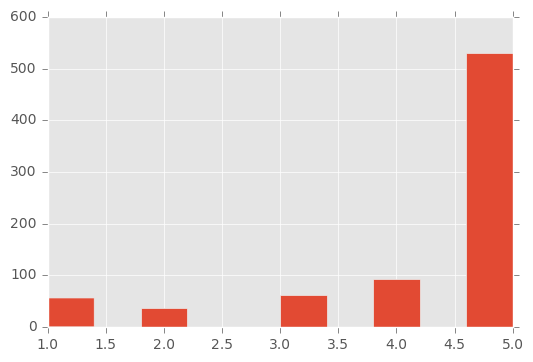

In [12]:
giraffe_reviews['rating'].hist()

In [13]:
giraffe_reviews['rating'].value_counts()

5    531
4     93
3     62
1     56
2     37
Name: rating, dtype: int64

# Build a sentiment classifier

## Define what's a positive and negative review

In [14]:
# Ignore all 3* review
products = products[products['rating'] != 3]

In [15]:
products['sentiment'] = products['rating'] >= 4

In [16]:
products.head()

,name,review,rating,word_counts,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",True
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",True
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",True
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",True
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",True


## Let's train the sentiment classifier

In [17]:
from sklearn.cross_validation import train_test_split

# Due to the random divide between the train and test data, the model will be 
# slightly different from the lectures from here on out.
train_data, test_data = train_test_split(products, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression

cv.fit(train_data['review']) # Use the count vector, but fit only the train data

sentiment_model = LogisticRegression().fit(cv.transform(train_data['review']), train_data['sentiment'])

In [19]:
# Predict sentiment for the test data, based on the sentiment model
# The cv.transform is necessary to get the test_data review data in the right format for the model
predicted = sentiment_model.predict(cv.transform(test_data['review']))

## Evaluate the sentiment model

In [20]:
from sklearn import metrics

# These metrics will be slightly different then in the lecture, due to the different
# train/test data split and differences in how the model is fitted

print ("Accuracy:", metrics.accuracy_score(test_data['sentiment'], predicted))
print ("ROC AUC Score:", metrics.roc_auc_score(test_data['sentiment'], predicted))
print ("Confusion matrix:")
print (metrics.confusion_matrix(test_data['sentiment'], predicted))
print (metrics.classification_report(test_data['sentiment'], predicted))

Accuracy: 0.936232496379
ROC AUC Score: 0.860505266666
Confusion matrix:
[[ 3997  1341]
 [  772 27026]]
             precision    recall  f1-score   support

      False       0.84      0.75      0.79      5338
       True       0.95      0.97      0.96     27798

avg / total       0.93      0.94      0.93     33136



In [21]:
# for the ROC curve, we need the prediction probabilities rather than the True/False values
# which are obtained by using the .predict_proba function instead of .predict
predicted_probs = sentiment_model.predict_proba(cv.transform(test_data['review']))

In [22]:
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(test_data['sentiment'], predicted_probs[:,1])

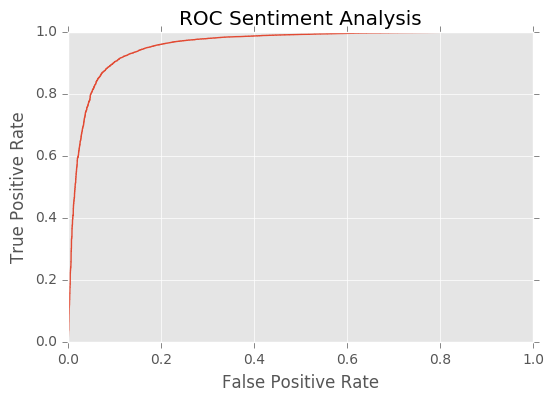

In [23]:
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Sentiment Analysis')
plt.show()

## Applying the learned model to understand sentiment for Giraffe

In [24]:
giraffe_reviews['predicted_sentiment'] = sentiment_model.predict_proba(cv.transform(giraffe_reviews['review']))[:,1]

In [25]:
giraffe_reviews.head()

,name,review,rating,word_counts,predicted_sentiment
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",0.998540
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",0.999326
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",0.340178
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",0.973703
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",0.335945


## Sort the reviews based on the predicted sentiment and explore

In [26]:
giraffe_reviews.sort_values(by='predicted_sentiment', inplace=True, ascending=False)

In [27]:
# Despite the slightly different model, the same review is ranked highest in predicted sentiment
giraffe_reviews.head(10)

,name,review,rating,word_counts,predicted_sentiment
34892,Vulli Sophie the Giraffe Teether,"Sophie, oh Sophie, your time has come. My gran...",5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34434,Vulli Sophie the Giraffe Teether,My Mom-in-Law bought Sophie for my son when he...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34515,Vulli Sophie the Giraffe Teether,"As every mom knows, you always want to give yo...",5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34442,Vulli Sophie the Giraffe Teether,"Yes, it\'s imported. Yes, it\'s expensive. And...",5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34341,Vulli Sophie the Giraffe Teether,I\'ll be honest...I bought this toy because al...,4,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34429,Vulli Sophie the Giraffe Teether,Let me just start off by addressing the chokin...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34746,Vulli Sophie the Giraffe Teether,Sophie the Giraffe is the perfect teething toy...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34975,Vulli Sophie the Giraffe Teether,My 8 week old LOVES Sophie. The rubber feels s...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
34410,Vulli Sophie the Giraffe Teether,Our son really likes Sopie...the problem is th...,5,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0
35035,Vulli Sophie the Giraffe Teether,"My 4 month old son is teething, and I\'ve trie...",4,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.0


In [28]:
giraffe_reviews.iloc[0]['review']

"Sophie, oh Sophie, your time has come. My granddaughter, Violet is 5 months old and starting to teeth. What joy little Sophie brings to Violet. Sophie is made of a very pliable rubber that is sturdy but not tough. It is quite easy for Violet to twist Sophie into unheard of positions to get Sophie into her mouth. The little nose and hooves fit perfectly into small mouths, and the drooling has purpose. The paint on Sophie is food quality.Sophie was born in 1961 in France. The maker had wondered why there was nothing available for babies and made Sophie from the finest rubber, phthalate-free on St Sophie\\'s Day, thus the name was born. Since that time millions of Sophie\\'s populate the world. She is soft and for babies little hands easy to grasp. Violet especially loves the bumpy head and horns of Sophie. Sophie has a long neck that easy to grasp and twist. She has lovely, sizable spots that attract Violet\\'s attention. Sophie has happy little squeaks that bring squeals of delight fro

## Let's look at the negative reviews

In [29]:
giraffe_reviews.tail(10)
## We can see the lowest scoring review in the lecture is ranked 10th lowest in this analysis

,name,review,rating,word_counts,predicted_sentiment
35018,Vulli Sophie the Giraffe Teether,"My son (now 2.5) LOVED his Sophie, and I bough...",1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",4.980937e-04
34706,Vulli Sophie the Giraffe Teether,Totally overpriced for what it is. Go to Pets...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",3.623238e-04
34556,Vulli Sophie the Giraffe Teether,"Alright, first off didn\'t realize this was a ...",2,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",3.557328e-04
34709,Vulli Sophie the Giraffe Teether,i looked at this teether forever before i fina...,4,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",2.725130e-04
34860,Vulli Sophie the Giraffe Teether,This children\'s toy is nostalgic and very cut...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.553006e-04
34824,Vulli Sophie the Giraffe Teether,I got one of these as a showe gift that my bab...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.473995e-04
34994,Vulli Sophie the Giraffe Teether,When I received this the paint was peeling off...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.093208e-04
34411,Vulli Sophie the Giraffe Teether,I was so looking forward to getting this for m...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.074097e-04
34732,Vulli Sophie the Giraffe Teether,Received the product and smells like cheap rub...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",5.586384e-05
34687,Vulli Sophie the Giraffe Teether,I wanted to love this product and was excited ...,1,"(0, 303)\t1\n (0, 3288)\t1\n (0, 4889)\t1\...",1.802705e-09


In [30]:
giraffe_reviews.iloc[-1]['review']

'I wanted to love this product and was excited to buy it when I became pregnant but am now hesitant to let my baby use it after reading about the recall in Europe. Apparently, as I understand it, their toxin standards of measurement are lower than ours so they have not been recalled here (apparently we are OK with low levels of nitrates in the toys our children put in their mouths, but Europeans are not...hmmm)...Be that as it may, toxins registering even CLOSE to a dangerous level made me nervous about using. After digging around online I did discover that the company claims to have changed the product after a certain date and lists manufacturing codes so you can check yours (those listed were made after a certain date and are said to be safer). Sadly mine was not made after the &#34;improved&#34; date but I could not return it because there was no formal recall in our country. I considered returning it and hunting for one with an approved manufacturing date but man that was just too 